In [1]:
import pandas as pd

In [2]:
import numpy as np 
from io import StringIO
from typing import Dict
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [3]:
def string_to_pandas(text):
    stringio = StringIO(text[1])
    df = pd.read_csv(stringio).drop('Unnamed: 0', axis=1)
    return get_keys(text[0]), df

def get_keys(x):
    try:
        name = os.path.basename(x)
        return "".join([s for s in name if s.isdigit()])
    except (IndexError, KeyError):
        return '', ''
    
def concat(x):
    train = x[1][0][1]
    train["train"] = 1
    
    val = x[1][1][1]
    val["train"] = 0
    
    train = pd.concat([train, gene_expression_train_bc.value], axis=1)
    val = pd.concat([val, gene_expression_validation_bc.value], axis=1)

    
    return pd.concat([train, val], axis=0, ignore_index=True)    


In [4]:
validation_rdd = sc.wholeTextFiles("gs://conrad-project/validation_prediction/spark_input_data/validation_combat_9_03_18/*", minPartitions=500)
training_rdd = sc.wholeTextFiles("gs://conrad-project/validation_prediction/spark_input_data/train_combat_9_03_18/*", minPartitions=500)

In [5]:
gene_expression_train = spark.read.option("header", True).csv("gs://conrad-project/validation_prediction/spark_input_data/training_set_gene_expression.csv").toPandas()
gene_expression_validation = spark.read.option("header", True).csv("gs://conrad-project/validation_prediction/spark_input_data/validation_set_gene_expression.csv").toPandas()

In [6]:
cols = [ "gene_" + c for c in gene_expression_train.columns.tolist()]
cols[0] = "name"
gene_expression_train.columns = cols
print(len(set(cols)))

cols = [ "gene_" + c for c in gene_expression_validation.columns.tolist()]
cols[0] = "name"
gene_expression_validation.columns = cols
print(len(set(cols)))

4684
4684


In [7]:
gene_expression_train_bc = sc.broadcast(gene_expression_train)
gene_expression_validation_bc = sc.broadcast(gene_expression_validation)

In [8]:
validation_rdd = validation_rdd.map(lambda x: string_to_pandas(x)).keyBy(lambda x: get_keys(x[0]))
training_rdd = training_rdd.map(lambda x: string_to_pandas(x)).keyBy(lambda x: get_keys(x[0]))
joined_rdd = training_rdd.join(validation_rdd, numPartitions=500).map(concat)


In [9]:
test = validation_rdd.take(1)[0]

In [10]:
t = joined_rdd.take(1)[0]

In [11]:
def forecast(data, target, features, clf):

    data = data.apply(pd.to_numeric, errors="ignore")
    data[target] = np.log(data[target])
    if data.shape[0] < 10:
        return []

    data = data.reset_index(drop=True)
    data_train = data[data["train"] == 1]
    data_test  =  data[(data["train"] == 0)]

    data_train = data_train.replace([np.inf, -np.inf], np.nan)
    data_test = data_test.replace([np.inf, -np.inf], np.nan)
    data_train = data_train.dropna(subset=features+[target])
    data_test = data_test.dropna(subset=features+[target])
    
    
    importances = []
    if data_test.shape[0] > 0:
        num_training = data_train.shape[0]
        df = pd.get_dummies(pd.concat([data_train, data_test])[features])

        X_train = df.iloc[:num_training, :]
        X_test = df.iloc[num_training:, :]

        y_train = data_train[target].values.ravel()
        y_test = data_test[target].values.ravel()

        clf.fit(X_train, y_train)
        prediction = clf.predict(X_test)
        data_test["prediction"] = np.exp(prediction)
        data_test["prediction_actual"] = np.exp(y_test)
        feature_imp = pd.Series(clf.feature_importances_)
        feature_imp.index = X_test.columns

        importances.append(feature_imp)
        for r in range (0, 0):
            np.random.shuffle(y_train)
            clf.fit(X_train, y_train)
            prediction = clf.predict(X_test)
            feature_imp = pd.Series(clf.feature_importances_)
            feature_imp.index = X_test.columns
            importances.append(feature_imp)
            data_test["prediction_{}".format(r)] = np.exp(prediction)
        return [data_test.filter(regex="prediction*"), pd.DataFrame(importances)]
    return []

In [12]:
clf = RandomForestRegressor(n_estimators=500,  max_features='auto', max_leaf_nodes=None, bootstrap=True,
                                oob_score=True, n_jobs=-1, random_state=None,
                                verbose=0, warm_start=True)


In [13]:
test = joined_rdd.take(1)[0]
features = test.drop(['BMI.catg', 'BMI.norm', 'name', 'train', 'Age.norm',
 'PC1',
 'PC2',
 'gender'], axis=1).columns.tolist()

In [14]:
forecast_rdd = joined_rdd.map(lambda x: forecast(x, "BMI.norm", features, clf))
predictions = forecast_rdd.collect()

In [15]:
results_pred = []
importances = []
for i, p in enumerate(predictions):
    pred = p[0]
    impor = p[1]
    pred["imputation_set"] = i
    impor["imputation_set"] = i
    importances.append(impor)
    results_pred.append(pred)
    

In [16]:
results_pred = pd.concat(results_pred)
importances = pd.concat(importances)
results_pred.to_csv("/home/tomi/results_pred.scv", index=False)
importances.to_csv("/home/tomi/importances.scv", index=False)

In [17]:

mean_squared_error(results_pred["prediction_actual"], results_pred["prediction"])

                   

61.36261379346617

In [19]:
importances_median = pd.DataFrame(importances.drop("imputation_set", axis=1).mean(), columns=
                                 ['value'])
importances_median = importances_median.sort_values("value", ascending=False)
importances_median['rank'] = range(1, importances_median.shape[0]+1)
importances_median['decile'] = np.digitize(importances_median['rank'], np.percentile(importances_median['rank'], np.arange(0, 100, 10)))


In [28]:
importances_median[importances_median["decile"]<4].to_csv("/repos/main/test.csv")

In [140]:
groups_deciles = importances_median.groupby("decile")

In [141]:
predictions_by_groups = []
for g in groups_deciles:
    genes_to_test = g[1].index.tolist()
    results_pred = run_prediction(joined_rdd, genes_to_test, clf)
    results_pred["decile"] = g[0]
    predictions_by_groups.append(results_pred)
predictions_by_groups = pd.concat(predictions_by_groups)
predictions_by_groups["error"] = ((predictions_by_groups["prediction_actual"] - predictions_by_groups["prediction"]))

In [142]:
from sklearn import metrics

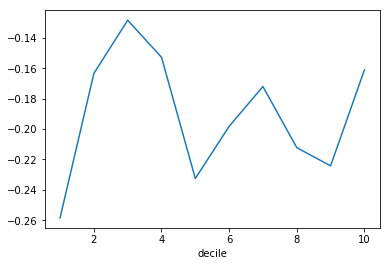

In [143]:
predictions_by_groups.groupby(["decile"]).apply(lambda x: metrics.r2_score(x["prediction_actual"],x["prediction"])).plot()

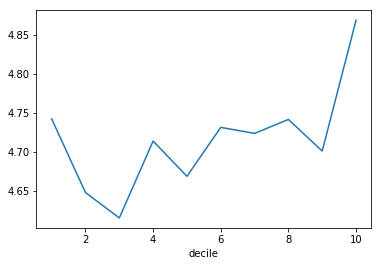

In [144]:
predictions_by_groups.groupby(["decile"]).apply(lambda x: metrics.median_absolute_error(x["prediction_actual"],x["prediction"])).plot()

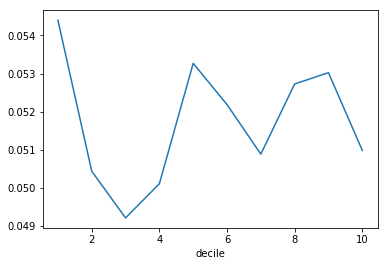

In [145]:
predictions_by_groups.groupby(["decile"]).apply(lambda x: metrics.mean_squared_log_error(x["prediction_actual"],x["prediction"])).plot()

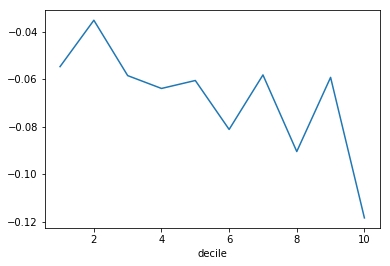

In [147]:
predictions_by_groups.groupby(["decile"]).apply(lambda x: metrics.explained_variance_score(x["prediction_actual"],x["prediction"])).plot()

groups_deciles = [g[1]for g in importances_rank_med.groupby("decile")]
groups_to_test = []
predictions_by_groups = []

for i in range(0,len(groups_deciles)):
    
    genes_to_test = []
    for j in range(0, i+1):
        genes_to_test.append(groups_deciles[j])
    genes_to_test = pd.concat(genes_to_test).index.tolist()
    
    forecast_rdd = joined_rdd.map(lambda x: forecast(x, "BMI.norm", genes_to_test, clf))
    pred = forecast_rdd.collect()
    results_pred = []
    for k, p in enumerate(pred):
        pred = p[0]
        pred["imputation_set"] = k
        results_pred.append(pred)
    results_pred = pd.concat(results_pred)
    results_pred["decile"] = i
    predictions_by_groups.append(results_pred)
    
predictions_by_groups = pd.concat(predictions_by_groups)
predictions_by_groups["error"] = ((predictions_by_groups["prediction_actual"] - predictions_by_groups["prediction"]))


sns.boxplot(x="decile", y="error", data=predictions_by_groups)

In [42]:
best_genes = pd.concat([groups_deciles.get_group(9), groups_deciles.get_group(10)]).index.tolist()

In [40]:
predictions_by_groups = []
for it in range(0,11):
    groups_to_test = []
    
    random_g = np.random.choice(7, 2, replace=False)
    print(random_g)
    g1 = groups_deciles.get_group(random_g[0]+1)
    g2 = groups_deciles.get_group(random_g[1]+1)
    g_cmbd = pd.concat([g1, g2]).index.tolist()
    if(it == 10):   
        g_cmbd = best_genes
    forecast_rdd = joined_rdd.map(lambda x: forecast(x, "BMI.norm", g_cmbd, clf))
    pred = forecast_rdd.collect()
    results_pred = []
    for k, p in enumerate(pred):
        pred = p[0]
        pred["imputation_set"] = k
        results_pred.append(pred)
    results_pred = pd.concat(results_pred)
    results_pred["iteration"] = it
    predictions_by_groups.append(results_pred)
    
predictions_by_groups = pd.concat(predictions_by_groups)
predictions_by_groups["error"] = ((predictions_by_groups["prediction_actual"] - predictions_by_groups["prediction"]))
predictions_by_groups["error_abs"] = np.abs(predictions_by_groups["error"])

[4 0]
[6 0]
[2 1]
[5 3]
[5 0]
[1 4]
[1 0]
[2 0]
[2 4]
[2 6]
[2 4]


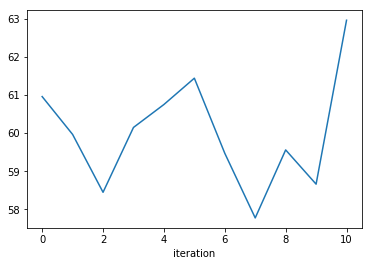

In [44]:
predictions_by_groups.groupby(["iteration"]).apply(lambda x: mean_squared_error(x["prediction_actual"],x["prediction"])).plot()


In [148]:
def run_prediction(joined_rdd, g_cmbd, clf):
    forecast_rdd = joined_rdd.map(lambda x: forecast(x, "BMI.norm", g_cmbd, clf))
    pred = forecast_rdd.collect()
    results_pred = []
    for k, p in enumerate(pred):
        pred = p[0]
        pred["imputation_set"] = k
        results_pred.append(pred)
    results_pred = pd.concat(results_pred)
    results_pred["error"] = ((results_pred["prediction_actual"] - results_pred["prediction"]))
    results_pred["error_abs"] = np.abs(results_pred["error"])
    return results_pred

In [ ]:
predictions_by_decile = []
for num_deciles in range(2,4):
    predictions_list = []
    top_i_deciles_start = 0
    top_i_deciles = np.array(range(top_i_deciles_start, 2))
    bad_i_deciles = np.array(range(2, 11))
    print("top deciles: {}".format(top_i_deciles))
    print("other deciles: {}".format(bad_i_deciles))

    top_i_deciles_genes = importances_median['decile'].isin(top_i_deciles).index.tolist()
    results = run_prediction(joined_rdd, top_i_deciles_genes, clf)
    results['type'] = "best"
    predictions_list.append(results)

    for it in range(0,10):
        random_g = np.random.choice(bad_i_deciles, num_deciles, replace=False)
        print("Random deciles: {}".format(random_g))
        random_decile_genes = importances_median['decile'].isin(random_g).index.tolist()
        results = run_prediction(joined_rdd, random_decile_genes, clf)
        results['type'] = it
        predictions_list.append(results)
    
    predictions_list = pd.concat(predictions_list)
    predictions_list['num_deciles'] = num_deciles
    predictions_by_decile.append(predictions_list)
predictions_by_decile = pd.concat(predictions_by_decile)

top deciles: [0 1]
other deciles: [ 2  3  4  5  6  7  8  9 10]
Random deciles: [10  3]
Random deciles: [9 3]
Random deciles: [2 3]
Random deciles: [ 9 10]
Random deciles: [10  9]
Random deciles: [10  4]
Random deciles: [6 5]
Random deciles: [4 2]
Random deciles: [9 3]
Random deciles: [2 6]
Random deciles: [2 6 3]
Random deciles: [2 4 9]
Random deciles: [9 8 7]
Random deciles: [ 3  6 10]
Random deciles: [2 8 5]
Random deciles: [9 5 2]


In [188]:
bla = predictions_by_decile.groupby(["num_deciles", 'type']).apply(lambda x: metrics.explained_variance_score(x["prediction_actual"],x["prediction"])).reset_index()

In [189]:
bla = bla.set_index(["num_deciles", 'type'])
bla.columns = ['score']

In [197]:
bla

score
num_deciles type          
2           0    -0.046327
            1    -0.042494
            2    -0.035827
            3    -0.036463
            4    -0.042674
            5    -0.036258
            6    -0.039057
            7    -0.039993
            8    -0.043157
            9    -0.055428
            best -0.062989
3           0    -0.039396
            1    -0.043917
            2    -0.040108
            3    -0.033506
            4    -0.038690
            5    -0.038824
            6    -0.042444
            7    -0.034694
            8    -0.038884
            9    -0.034848
            best -0.040336